# [How to train an object detection model easy for free](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/) | DLology Blog

In [36]:
# Mount my Google Drive and save modeling ckpt file there, so that it won't be wiped out when colab VM restarts.  
# Google will ask for an authenticate code
from google.colab import drive
drive.mount('/content/gdrive')
model_dir = '/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training'
#!rm -rf '{model_dir}'
#os.makedirs(model_dir, exist_ok=True)
!ls -ltra '{model_dir}'/..

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 3803
drwx------ 2 root root    4096 Apr  4 04:07  object_detection_demo
drwx------ 2 root root    4096 Apr  4 04:07  images
drwx------ 2 root root    4096 Apr  5 03:49  EdgeTPU
drwx------ 2 root root    4096 Apr  5 05:33  Training
drwx------ 2 root root    4096 Apr 14 04:41 'Training - Nuts'
-rw------- 1 root root 1935636 Apr 15 02:47  tensorflow_object_detection_training_colab_v2.ipynb
-rw------- 1 root root 1937373 Apr 15 03:35  tensorflow_traffic_sign_detection.ipynb


## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [0]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/dctian/DeepPiCar'

# Number of training steps.
num_steps = 1000  # 200000
#num_steps = 100  # 200000

# Number of evaluation steps.
num_eval_steps = 50


# model configs are from Model Zoo github: 
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models
MODELS_CONFIG = {
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz
    'ssd_mobilenet_v1_quantized': {
        'model_name': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18',
        'pipeline_file': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync.config',
        'batch_size': 12
    },    
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03.tar.gz
    'ssd_mobilenet_v2_quantized': {
        'model_name': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03',
        'pipeline_file': 'ssd_mobilenet_v2_quantized_300x300_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 12
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
# Note: for Edge TPU, you have to:
# 1) start with a pretrained model from model zoo, such as above 4
# 2) Must be a quantized model, which reduces the model size significantly
selected_model = 'ssd_mobilenet_v2_quantized'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `DeepPiCar` repository or your fork.

In [12]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}

print('Pull it so that we have the latest code/data')
!git pull

/content
fatal: destination path 'DeepPiCar' already exists and is not an empty directory.
/content/DeepPiCar
Pull it so that we have the latest code/data
Already up to date.


## Install required packages

In [10]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
/content/models/research

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

............s...
----------------------------------------------------------------------
Ran 16 tests in 0.076s

OK (skipped=1)


## Prepare `tfrecord` files

Use the following scripts to generate the `tfrecord` files.
```bash
# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt
```

In [15]:
%cd {repo_dir_path}/models/object_detection

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python code/xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
!python code/xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
!python code/generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
!python code/generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt

/content/DeepPiCar/models/object_detection
Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`
Successfully converted xml to csv.
Successfully created the TFRecords: /content/DeepPiCar/models/object_detection/data/annotations/train.record
Successfully created the TFRecords: /content/DeepPiCar/models/object_detection/data/annotations/test.record


In [0]:
test_record_fname = repo_dir_path + '/models/object_detection/data/annotations/test.record'
train_record_fname = repo_dir_path + '/models/object_detection/data/annotations/train.record'
label_map_pbtxt_fname = repo_dir_path + '/models/object_detection/data/annotations/label_map.pbtxt'

In [24]:
!cat data/annotations/test_labels.csv

filename,width,height,class,xmin,ymin,xmax,ymax
car_video_4_273.png,320,240,Speed Limit 40,150,74,163,89
car_video_4_273.png,320,240,Stop Sign,271,88,280,100
car_video_5_320.png,320,240,Speed Limit 40,74,70,93,95
car_video_5_320.png,320,240,Stop Sign,262,85,276,103
car_video_4_002.png,320,240,Red Traffic Light,56,77,75,94
car_video_4_002.png,320,240,Red Traffic Light,210,78,220,100
car_video_3_100.png,320,240,Speed Limit 25,116,73,129,86
car_video_3_100.png,320,240,Stop Sign,19,82,32,95
car_video_6_246.png,320,240,Person,116,89,125,106
car_video_6_246.png,320,240,Person,72,89,80,105


## Download base model

In [25]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [26]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 204M
drwx------  2 303230 5000 4.0K Jan  4 18:43 .
drwxr-xr-x 71 root   root 4.0K Apr 15 03:33 ..
-rw-------  1 303230 5000  93M Jan  4 18:41 model.ckpt.data-00000-of-00001
-rw-------  1 303230 5000  68K Jan  4 18:41 model.ckpt.index
-rw-------  1 303230 5000  20M Jan  4 18:41 model.ckpt.meta
-rw-------  1 303230 5000 4.3K Jan  4 18:41 pipeline.config
-rw-------  1 303230 5000  24M Jan  4 18:43 tflite_graph.pb
-rw-------  1 303230 5000  68M Jan  4 18:43 tflite_graph.pbtxt


In [27]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [0]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [0]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [0]:
import re

# training pipeline file defines:
# - pretrain model path
# - the train/test sets
# - ID to Label mapping and number of classes
# - training batch size
# - epochs to trains
# - learning rate
# - etc

# note we just need to use a sample one, and make edits to it.

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint: downloaded pre-trained model checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test, we created earlier with our training/test sets
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path: ID to label file
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps (Number of epochs to train)
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [31]:
!cat {label_map_pbtxt_fname}

item {
    id: 1
    name: 'Green Traffic Light'
}

item {
    id: 2
    name: 'Person'
}

item {
    id: 3
    name: 'Red Traffic Light'
}

item {
    id: 4
    name: 'Speed Limit 25'
}

item {
    id: 5
    name: 'Speed Limit 40'
}

item {
    id: 6
    name: 'Stop Sign'
}

In [33]:
# look for num_classes: 6, since we have 5 different road signs and 1 person type (total of 6 types) 
!cat {pipeline_fname}

# Quantized trained SSD with Mobilenet v2 on MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 6
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspe

## Run Tensorboard(Optional)

In [34]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2019-04-15 03:35:27--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.199.255.1, 34.231.75.48, 52.73.94.166, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.199.255.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.28M  37.0MB/s    in 0.4s    

2019-04-15 03:35:28 (37.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir "{}" --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [39]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://e9cd9046.ngrok.io


## Train the model

Now all inputs are set up, just train the model.   This process may take a few hours.   Since we are saving the model training results (model.ckpt-* files) in our google drive (a persistent storage that will survice the restart of our colab VM instance), we can safely leave and return a few hours later. 

In [0]:
#################### SEND ALERT EMAIL AT FINISH WITH GMAIL #####################
# To send email from Python from your google account, MUST 
# 1) Enable less secure app
# https://myaccount.google.com/lesssecureapps
# 2) Disable Unlock Capcha
# https://accounts.google.com/b/0/DisplayUnlockCaptcha

import smtplib

def SendEmail(msg):
    gmail_user = 'david.tian@gmail.com'  
    gmail_password = '96t$USU839'

    sent_from = gmail_user  
    to = ['dctian@hotmail.com']  
    subject = msg  
    body = '%s\n\n- David' % msg

    email_text = \
"""From: %s
To: %s
Subject: %s

%s
""" % (sent_from, ", ".join(to), subject, body)

    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.ehlo()
    server.starttls()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, email_text)
    server.quit()

    print(f'Email: \n{email_text}')
    

In [0]:
SendEmail("Colab train started")
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir='{model_dir}' \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}
SendEmail("Colab train finished")

Email: 
From: david.tian@gmail.com
To: dctian@hotmail.com
Subject: Colab train started

Colab train started

- David


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.
2019-04-15 04:14:56.131930: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-04-15 04:14:56.132228: I tensorflow/co

In [42]:
!ls -ltra '{model_dir}'

total 368018
-rw------- 1 root root 32662689 Apr 15 03:39 graph.pbtxt
-rw------- 1 root root    68804 Apr 15 03:39 model.ckpt-0.index
-rw------- 1 root root 75237296 Apr 15 03:39 model.ckpt-0.data-00000-of-00001
-rw------- 1 root root 17817892 Apr 15 03:39 model.ckpt-0.meta
-rw------- 1 root root    68804 Apr 15 03:49 model.ckpt-57.index
-rw------- 1 root root 75237296 Apr 15 03:49 model.ckpt-57.data-00000-of-00001
-rw------- 1 root root 17817892 Apr 15 03:50 model.ckpt-57.meta
drwx------ 2 root root     4096 Apr 15 03:50 eval_0
-rw------- 1 root root    68804 Apr 15 03:57 model.ckpt-100.index
-rw------- 1 root root 75237296 Apr 15 03:57 model.ckpt-100.data-00000-of-00001
-rw------- 1 root root      172 Apr 15 03:57 checkpoint
-rw------- 1 root root 17817892 Apr 15 03:57 model.ckpt-100.meta
-rw------- 1 root root 64804676 Apr 15 03:57 events.out.tfevents.1555299553.9155177eabc2
drwx------ 3 root root     4096 Apr 15 03:57 export


## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [0]:
import os
import re
import numpy as np

output_directory = '%s/fine_tuned_model' % model_dir
os.makedirs(output_directory, exist_ok=True)

In [44]:
lst = os.listdir(model_dir)
# find the last model checkpoint file, i.e. model.ckpt-1000.meta
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)


/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/model.ckpt-100


In [45]:
!echo creates the frozen inference graph in fine_tune_model
# there is an "Incomplete shape" message.  but we can safely ignore that. 
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory='{output_directory}' \
    --trained_checkpoint_prefix='{last_model_path}'

creates the frozen inference graph in fine_tune_model
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
281 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step       

In [46]:
# https://medium.com/tensorflow/training-and-serving-a-realtime-mobile-object-detector-in-30-minutes-with-cloud-tpus-b78971cf1193
# create the tensorflow lite graph
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path={pipeline_fname} \
    --trained_checkpoint_prefix='{last_model_path}' \
    --output_directory='{output_directory}' \
    --add_postprocessing_op=true

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
2019-04-15 04:08:03.394841: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-04-15 04:08:03.395164: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x265a680 executing computations on platform Host. Devices:
2019-04-15 04:08:03.395206: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
Instructions for updating:
Use standard file APIs to check for files with this prefix.
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
2019-04-15 04:08:09.250803: I tensorflow/tools/graph_transforms/transform_graph.cc:317] Applying strip_unused_nodes


In [47]:
!echo "CONVERTING frozen graph to quantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_quantized.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

CONVERTING frozen graph to quantized TF Lite file...
2019-04-15 04:08:30.560527: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-04-15 04:08:30.564534: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55ecd0b74dc0 executing computations on platform Host. Devices:
2019-04-15 04:08:30.564652: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


In [48]:
!echo "CONVERTING frozen graph to unquantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_float.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops 


CONVERTING frozen graph to unquantized TF Lite file...
2019-04-15 04:08:54.544238: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-04-15 04:08:54.544636: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x56022ec80dc0 executing computations on platform Host. Devices:
2019-04-15 04:08:54.544714: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


In [49]:
print(output_directory)
!ls -ltra '{output_directory}'
#pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb") # this is main one
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")  # this is tflite graph
!cp '{label_map_pbtxt_fname}' '{output_directory}'

/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/fine_tuned_model
total 134757
-rw------- 1 root root    23543 Apr 15 04:06 model.ckpt.index
-rw------- 1 root root 18922628 Apr 15 04:06 model.ckpt.data-00000-of-00001
-rw------- 1 root root       77 Apr 15 04:06 checkpoint
-rw------- 1 root root  2120806 Apr 15 04:06 model.ckpt.meta
-rw------- 1 root root 19755137 Apr 15 04:07 frozen_inference_graph.pb
drwx------ 3 root root     4096 Apr 15 04:07 saved_model
-rw------- 1 root root     4471 Apr 15 04:07 pipeline.config
-rw------- 1 root root 19406623 Apr 15 04:08 tflite_graph.pb
-rw------- 1 root root 54164592 Apr 15 04:08 tflite_graph.pbtxt
-rw------- 1 root root  4793504 Apr 15 04:08 road_signs_quantized.tflite
-rw------- 1 root root 18792240 Apr 15 04:08 road_signs_float.tflite


## Run inference test
Test with images in repository `object_detection/data/images/test` directory.

In [54]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname
print(PATH_TO_CKPT)

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "models/object_detection/data/images/test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.png"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/fine_tuned_model/frozen_inference_graph.pb
['/content/DeepPiCar/models/object_detection/data/images/test/car_video_6_246.png', '/content/DeepPiCar/models/object_detection/data/images/test/car_video_4_002.png', '/content/DeepPiCar/models/object_detection/data/images/test/car_video_5_320.png', '/content/DeepPiCar/models/object_detection/data/images/test/car_video_3_100.png', '/content/DeepPiCar/models/object_detection/data/images/test/car_video_4_273.png']


In [55]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict



/content/models/research/object_detection


Running inferences on ['/content/DeepPiCar/models/object_detection/data/images/test/car_video_6_246.png', '/content/DeepPiCar/models/object_detection/data/images/test/car_video_4_002.png', '/content/DeepPiCar/models/object_detection/data/images/test/car_video_5_320.png', '/content/DeepPiCar/models/object_detection/data/images/test/car_video_3_100.png', '/content/DeepPiCar/models/object_detection/data/images/test/car_video_4_273.png']


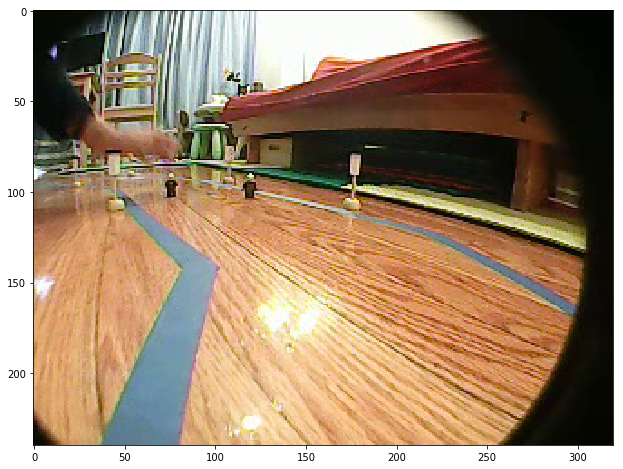

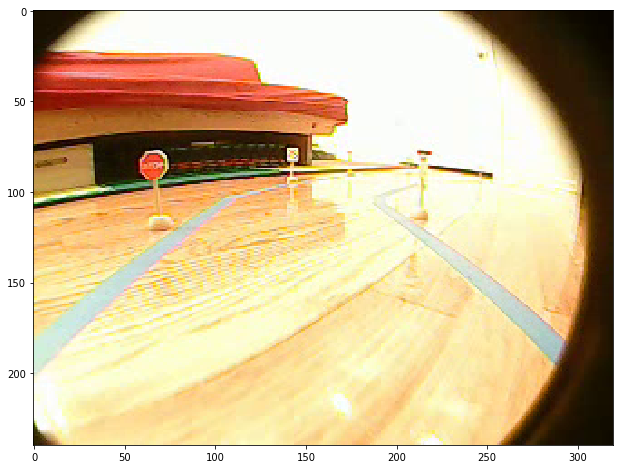

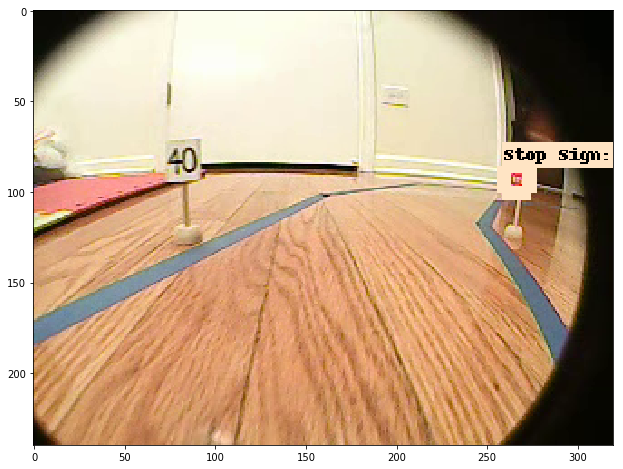

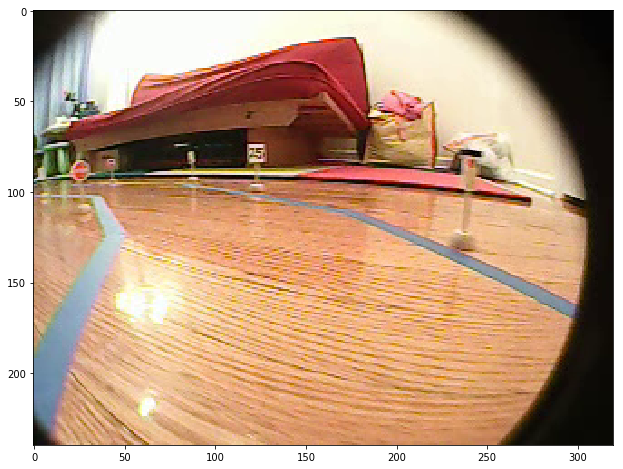

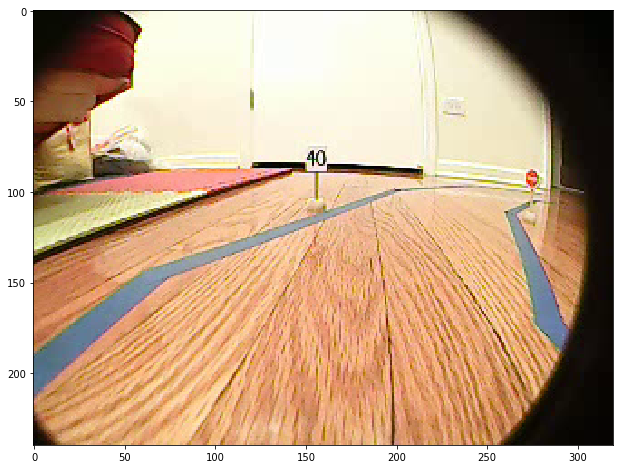

In [56]:
# running inferences.  This should show images with bounding boxes
%matplotlib inline

print('Running inferences on %s' % TEST_IMAGE_PATHS)
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)